## Random Forest Regressor - Usando diferenças

In [256]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
#get_ipython().run_line_magic('matplolib', 'inline')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [257]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

#Função para avaliação de métricas de erros
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')

    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')

    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')

    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')

    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')

    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return

#Função para avaliação da estacionaridade dos dados da série temporal
def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')


def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Carregamento e leitura dos dados

In [258]:
grupo = 'Adesão - Grande - Filantropia' 

grupo_csv = "ade_g_filan.csv"

#path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

#Amostra do dataframe
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          32 non-null     int64  
 1   cd_ops       32 non-null     int64  
 2   trimestre    32 non-null     object 
 3   receita      32 non-null     float64
 4   despesa      32 non-null     float64
 5   benef        32 non-null     float64
 6   modalidade   32 non-null     object 
 7   port_ops     32 non-null     object 
 8   contratacao  32 non-null     object 
dtypes: float64(3), int64(2), object(4)
memory usage: 2.4+ KB


In [259]:
ind_econ = 'ind_econ.csv'

df_ind_econ = pd.read_csv(ind_econ, sep=';', decimal= ',', encoding='mbcs')

df_ind_econ = df_ind_econ[(df_ind_econ.trimestre > '2017Q4') & (df_ind_econ.trimestre < '2022Q1')]

df_ind_econ = df_ind_econ.reset_index(drop=True)

df_ind_econ['trimestre'] = pd.PeriodIndex(df_ind_econ['trimestre'], freq="Q")

df_ind_econ['Dolar_diff'] = df_ind_econ['Dolar'].diff(1) 

df_ind_econ.info()

df_ind_econ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   trimestre   16 non-null     period[Q-DEC]
 1   IPCA        16 non-null     float64      
 2   Selic       16 non-null     float64      
 3   Dolar       16 non-null     float64      
 4   Dolar_diff  15 non-null     float64      
dtypes: float64(4), period[Q-DEC](1)
memory usage: 768.0 bytes


,trimestre,IPCA,Selic,Dolar,Dolar_diff
0,2018Q1,0.007015,0.000158,3.245100,NaN
1,2018Q2,0.018887,0.000156,3.457233,0.212133
2,2018Q3,0.007209,0.000158,3.853900,0.396667
3,2018Q4,0.003894,0.000152,3.904500,0.050600
4,2019Q1,0.015070,0.000150,3.776467,-0.128033
5,2019Q2,0.007108,0.000153,3.903500,0.127033
6,2019Q3,0.002601,0.000153,3.882133,-0.021367
7,2019Q4,0.017675,0.000123,4.131167,0.249034
8,2020Q1,0.005308,0.000101,4.191133,0.059966
9,2020Q2,-0.004306,0.000073,5.272333,1.081200


In [260]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                    'despesa':lambda x: sum_million(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('float')

ans_agrup['n_tri_l1'] = ans_agrup['n_tri'].shift(1)

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

#Tratamento dados benef

ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

ans_agrup['benefm_diff'] = ans_agrup['benefm'].diff(1)

ans_agrup['benefm_diff_l1'] = ans_agrup['benefm_diff'].shift(1)

#Tratamento dados receita

ans_agrup['receita_l1'] = ans_agrup['receita'].shift(1)

ans_agrup['receita_l2'] = ans_agrup['receita'].shift(2)

ans_agrup['receita_diff'] = ans_agrup['receita'].diff(1)

ans_agrup['receita_diff_l1'] = ans_agrup['receita_diff'].shift(1)

ans_agrup['receita_diff_l2'] = ans_agrup['receita_diff'].shift(2)

#Tratamento dados despesa

ans_agrup['despesa_l1'] = ans_agrup['despesa'].shift(1)

ans_agrup['despesa_l2'] = ans_agrup['despesa'].shift(2)


ans_agrup['despesa_diff'] = ans_agrup['despesa'].diff(1)

ans_agrup['despesa_diff_l1'] = ans_agrup['despesa_diff'].shift(1)

ans_agrup['despesa_diff_l2'] = ans_agrup['despesa_diff'].shift(2)


ans_agrup['despesa_diff2'] = ans_agrup['despesa'].diff(2)

ans_agrup['despesa_diff2_l1'] = ans_agrup['despesa_diff2'].shift(1)

ans_agrup['despesa_diff2_l2'] = ans_agrup['despesa_diff2'].shift(2)

#Variáveis Dummies

#ans_agrup['dmy_outlier'] = np.where(ans_agrup['trimestre'] == '2019Q1',0.0,1.0)

ans_agrup['dmy_covid'] = np.where((ans_agrup['trimestre'] >= '2020Q1') & (ans_agrup['trimestre'] <= '2020Q3'),0.0,1.0)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype        
---  ------            --------------  -----        
 0   trimestre         16 non-null     period[Q-DEC]
 1   receita           16 non-null     float64      
 2   despesa           16 non-null     float64      
 3   benef             16 non-null     int32        
 4   n_ops             16 non-null     int32        
 5   pct_despesa       16 non-null     float64      
 6   ano               16 non-null     int32        
 7   n_tri             16 non-null     float64      
 8   n_tri_l1          15 non-null     float64      
 9   benefm            16 non-null     float64      
 10  benefm_diff       15 non-null     float64      
 11  benefm_diff_l1    14 non-null     float64      
 12  receita_l1        15 non-null     float64      
 13  receita_l2        14 non-null     float64      
 14  receita_diff      15 non-null     float64   

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid
0,2018Q1,14.280000,10.230000,24320,2,71.640000,2018,1.000000,NaN,8106.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,2018Q2,14.880000,11.770000,23958,2,79.100000,2018,2.000000,1.000000,7986.000000,-120.666667,NaN,14.280000,NaN,0.600000,NaN,NaN,10.230000,NaN,1.540000,NaN,NaN,NaN,NaN,NaN,1.000000
2,2018Q3,15.680000,11.840000,23080,2,75.510000,2018,3.000000,2.000000,7693.333333,-292.666667,-120.666667,14.880000,14.280000,0.800000,0.600000,NaN,11.770000,10.230000,0.070000,1.540000,NaN,1.610000,NaN,NaN,1.000000
3,2018Q4,15.960000,10.660000,22545,2,66.790000,2018,4.000000,3.000000,7515.000000,-178.333333,-292.666667,15.680000,14.880000,0.280000,0.800000,0.600000,11.840000,11.770000,-1.180000,0.070000,1.540000,-1.110000,1.610000,NaN,1.000000
4,2019Q1,15.560000,10.750000,21998,2,69.090000,2019,1.000000,4.000000,7332.666667,-182.333333,-178.333333,15.960000,15.680000,-0.400000,0.280000,0.800000,10.660000,11.840000,0.090000,-1.180000,0.070000,-1.090000,-1.110000,1.610000,1.000000
5,2019Q2,15.250000,11.960000,21510,2,78.430000,2019,2.000000,1.000000,7170.000000,-162.666667,-182.333333,15.560000,15.960000,-0.310000,-0.400000,0.280000,10.750000,10.660000,1.210000,0.090000,-1.180000,1.300000,-1.090000,-1.110000,1.000000
6,2019Q3,15.810000,11.370000,20940,2,71.920000,2019,3.000000,2.000000,6980.000000,-190.000000,-162.666667,15.250000,15.560000,0.560000,-0.310000,-0.400000,11.960000,10.750000,-0.590000,1.210000,0.090000,0.620000,1.300000,-1.090000,1.000000
7,2019Q4,15.530000,13.370000,20368,2,86.090000,2019,4.000000,3.000000,6789.333333,-190.666667,-190.000000,15.810000,15.250000,-0.280000,0.560000,-0.310000,11.370000,11.960000,2.000000,-0.590000,1.210000,1.410000,0.620000,1.300000,1.000000
8,2020Q1,14.890000,10.160000,19529,2,68.230000,2020,1.000000,4.000000,6509.666667,-279.666667,-190.666667,15.530000,15.810000,-0.640000,-0.280000,0.560000,13.370000,11.370000,-3.210000,2.000000,-0.590000,-1.210000,1.410000,0.620000,0.000000
9,2020Q2,15.100000,7.990000,18780,2,52.910000,2020,2.000000,1.000000,6260.000000,-249.666667,-279.666667,14.890000,15.530000,0.210000,-0.640000,-0.280000,10.160000,13.370000,-2.170000,-3.210000,2.000000,-5.380000,-1.210000,1.410000,0.000000


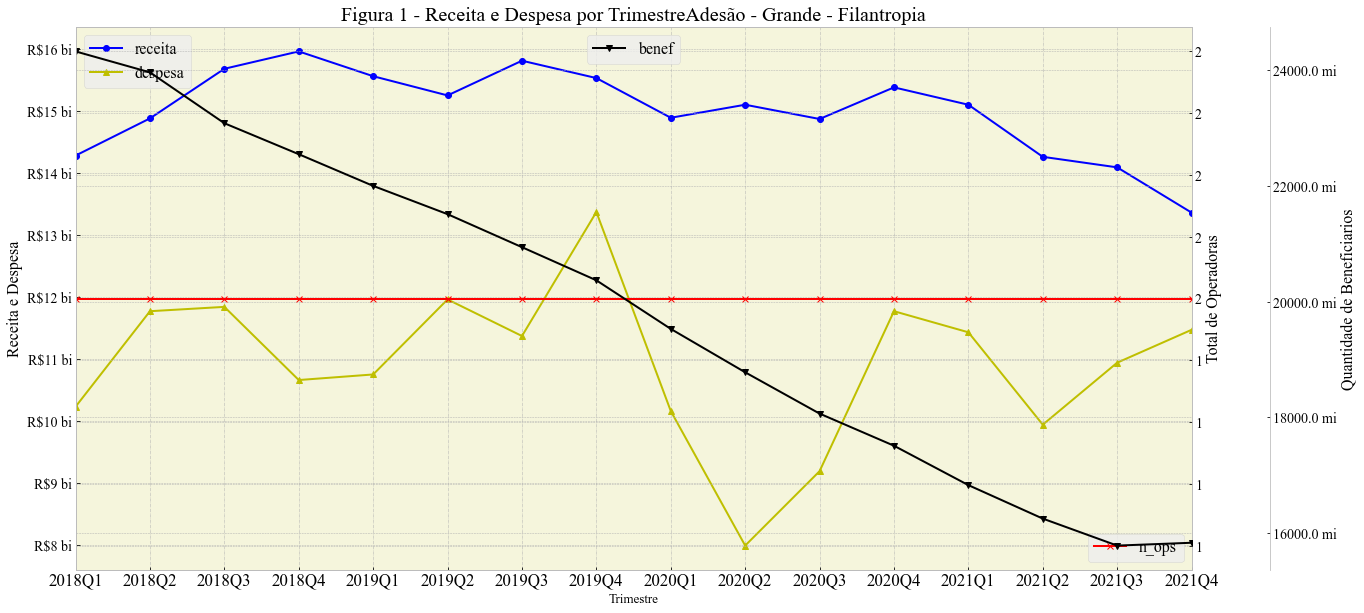

In [261]:
df_plot = ans_agrup.copy()

df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre' + grupo,fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [262]:
ans_agrup = ans_agrup.merge(df_ind_econ, how='left', on='trimestre')

ans_agrup

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,IPCA,Selic,Dolar,Dolar_diff
0,2018Q1,14.280000,10.230000,24320,2,71.640000,2018,1.000000,NaN,8106.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.007015,0.000158,3.245100,NaN
1,2018Q2,14.880000,11.770000,23958,2,79.100000,2018,2.000000,1.000000,7986.000000,-120.666667,NaN,14.280000,NaN,0.600000,NaN,NaN,10.230000,NaN,1.540000,NaN,NaN,NaN,NaN,NaN,1.000000,0.018887,0.000156,3.457233,0.212133
2,2018Q3,15.680000,11.840000,23080,2,75.510000,2018,3.000000,2.000000,7693.333333,-292.666667,-120.666667,14.880000,14.280000,0.800000,0.600000,NaN,11.770000,10.230000,0.070000,1.540000,NaN,1.610000,NaN,NaN,1.000000,0.007209,0.000158,3.853900,0.396667
3,2018Q4,15.960000,10.660000,22545,2,66.790000,2018,4.000000,3.000000,7515.000000,-178.333333,-292.666667,15.680000,14.880000,0.280000,0.800000,0.600000,11.840000,11.770000,-1.180000,0.070000,1.540000,-1.110000,1.610000,NaN,1.000000,0.003894,0.000152,3.904500,0.050600
4,2019Q1,15.560000,10.750000,21998,2,69.090000,2019,1.000000,4.000000,7332.666667,-182.333333,-178.333333,15.960000,15.680000,-0.400000,0.280000,0.800000,10.660000,11.840000,0.090000,-1.180000,0.070000,-1.090000,-1.110000,1.610000,1.000000,0.015070,0.000150,3.776467,-0.128033
5,2019Q2,15.250000,11.960000,21510,2,78.430000,2019,2.000000,1.000000,7170.000000,-162.666667,-182.333333,15.560000,15.960000,-0.310000,-0.400000,0.280000,10.750000,10.660000,1.210000,0.090000,-1.180000,1.300000,-1.090000,-1.110000,1.000000,0.007108,0.000153,3.903500,0.127033
6,2019Q3,15.810000,11.370000,20940,2,71.920000,2019,3.000000,2.000000,6980.000000,-190.000000,-162.666667,15.250000,15.560000,0.560000,-0.310000,-0.400000,11.960000,10.750000,-0.590000,1.210000,0.090000,0.620000,1.300000,-1.090000,1.000000,0.002601,0.000153,3.882133,-0.021367
7,2019Q4,15.530000,13.370000,20368,2,86.090000,2019,4.000000,3.000000,6789.333333,-190.666667,-190.000000,15.810000,15.250000,-0.280000,0.560000,-0.310000,11.370000,11.960000,2.000000,-0.590000,1.210000,1.410000,0.620000,1.300000,1.000000,0.017675,0.000123,4.131167,0.249034
8,2020Q1,14.890000,10.160000,19529,2,68.230000,2020,1.000000,4.000000,6509.666667,-279.666667,-190.666667,15.530000,15.810000,-0.640000,-0.280000,0.560000,13.370000,11.370000,-3.210000,2.000000,-0.590000,-1.210000,1.410000,0.620000,0.000000,0.005308,0.000101,4.191133,0.059966
9,2020Q2,15.100000,7.990000,18780,2,52.910000,2020,2.000000,1.000000,6260.000000,-249.666667,-279.666667,14.890000,15.530000,0.210000,-0.640000,-0.280000,10.160000,13.370000,-2.170000,-3.210000,2.000000,-5.380000,-1.210000,1.410000,0.000000,-0.004306,0.000073,5.272333,1.081200


In [263]:
ans_agrup.set_index('trimestre', inplace=True)

ans_agrup_full = ans_agrup.copy()

In [264]:
ans_agrup_full['benefm'].iloc[-1]

5279.0

In [265]:
ans_agrup = ans_agrup.dropna()

#informações sobre o data frame
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2019Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receita           12 non-null     float64
 1   despesa           12 non-null     float64
 2   benef             12 non-null     int32  
 3   n_ops             12 non-null     int32  
 4   pct_despesa       12 non-null     float64
 5   ano               12 non-null     int32  
 6   n_tri             12 non-null     float64
 7   n_tri_l1          12 non-null     float64
 8   benefm            12 non-null     float64
 9   benefm_diff       12 non-null     float64
 10  benefm_diff_l1    12 non-null     float64
 11  receita_l1        12 non-null     float64
 12  receita_l2        12 non-null     float64
 13  receita_diff      12 non-null     float64
 14  receita_diff_l1   12 non-null     float64
 15  receita_diff_l2   12 non-null     float64
 16  despesa_l1        12 non

In [266]:
columns_receita = ['receita','receita_diff','despesa','despesa_diff']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,IPCA,Selic,Dolar,Dolar_diff
trimestre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019Q1,15.560000,10.750000,21998,2,69.090000,2019,1.000000,4.000000,7332.666667,-182.333333,-178.333333,15.960000,15.680000,-0.400000,0.280000,0.800000,10.660000,11.840000,0.090000,-1.180000,0.070000,-1.090000,-1.110000,1.610000,1.000000,0.015070,0.000150,3.776467,-0.128033
2019Q2,15.250000,11.960000,21510,2,78.430000,2019,2.000000,1.000000,7170.000000,-162.666667,-182.333333,15.560000,15.960000,-0.310000,-0.400000,0.280000,10.750000,10.660000,1.210000,0.090000,-1.180000,1.300000,-1.090000,-1.110000,1.000000,0.007108,0.000153,3.903500,0.127033
2019Q3,15.810000,11.370000,20940,2,71.920000,2019,3.000000,2.000000,6980.000000,-190.000000,-162.666667,15.250000,15.560000,0.560000,-0.310000,-0.400000,11.960000,10.750000,-0.590000,1.210000,0.090000,0.620000,1.300000,-1.090000,1.000000,0.002601,0.000153,3.882133,-0.021367
2019Q4,15.530000,13.370000,20368,2,86.090000,2019,4.000000,3.000000,6789.333333,-190.666667,-190.000000,15.810000,15.250000,-0.280000,0.560000,-0.310000,11.370000,11.960000,2.000000,-0.590000,1.210000,1.410000,0.620000,1.300000,1.000000,0.017675,0.000123,4.131167,0.249034
2020Q1,14.890000,10.160000,19529,2,68.230000,2020,1.000000,4.000000,6509.666667,-279.666667,-190.666667,15.530000,15.810000,-0.640000,-0.280000,0.560000,13.370000,11.370000,-3.210000,2.000000,-0.590000,-1.210000,1.410000,0.620000,0.000000,0.005308,0.000101,4.191133,0.059966
2020Q2,15.100000,7.990000,18780,2,52.910000,2020,2.000000,1.000000,6260.000000,-249.666667,-279.666667,14.890000,15.530000,0.210000,-0.640000,-0.280000,10.160000,13.370000,-2.170000,-3.210000,2.000000,-5.380000,-1.210000,1.410000,0.000000,-0.004306,0.000073,5.272333,1.081200
2020Q3,14.870000,9.190000,18067,2,61.800000,2020,3.000000,2.000000,6022.333333,-237.666667,-249.666667,15.100000,14.890000,-0.230000,0.210000,-0.640000,7.990000,10.160000,1.200000,-2.170000,-3.210000,-0.970000,-5.380000,-1.210000,0.000000,0.012447,0.000051,5.307533,0.035200
2020Q4,15.380000,11.770000,17512,2,76.530000,2020,4.000000,3.000000,5837.333333,-185.000000,-237.666667,14.870000,15.100000,0.510000,-0.230000,0.210000,9.190000,7.990000,2.580000,1.200000,-2.170000,3.780000,-0.970000,-5.380000,1.000000,0.031314,0.000047,5.458467,0.150934
2021Q1,15.100000,11.430000,16832,2,75.700000,2021,1.000000,4.000000,5610.666667,-226.666667,-185.000000,15.380000,14.870000,-0.280000,0.510000,-0.230000,11.770000,9.190000,-0.340000,2.580000,1.200000,2.240000,3.780000,-0.970000,1.000000,0.020525,0.000048,5.249900,-0.208567


receita


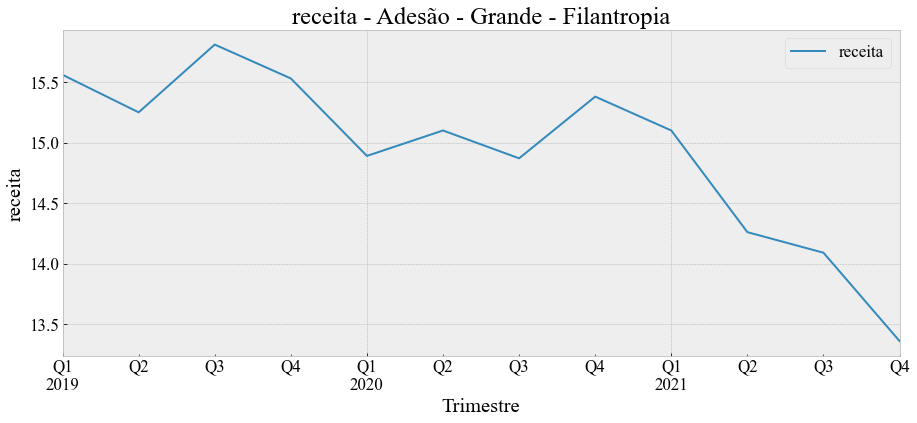

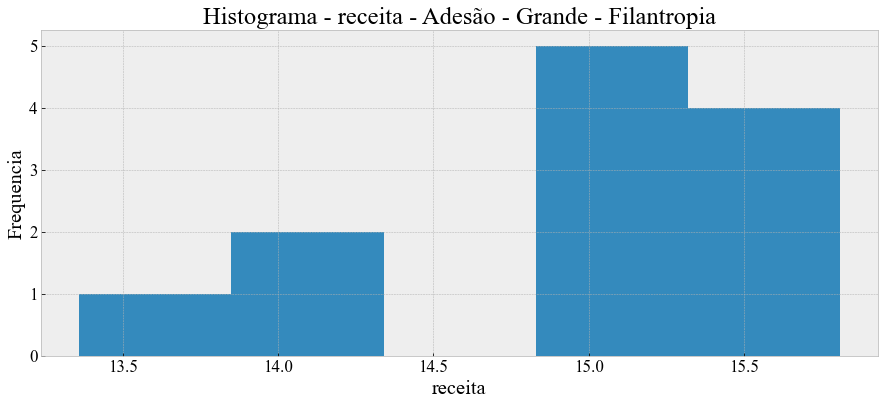

receita_diff


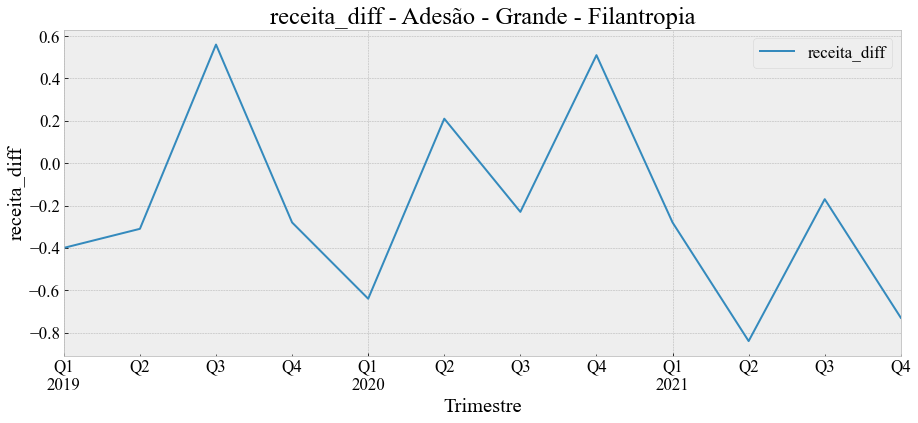

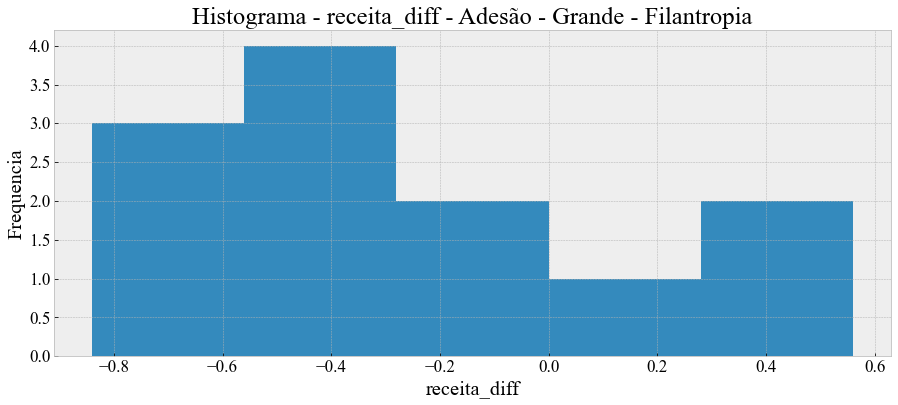

despesa


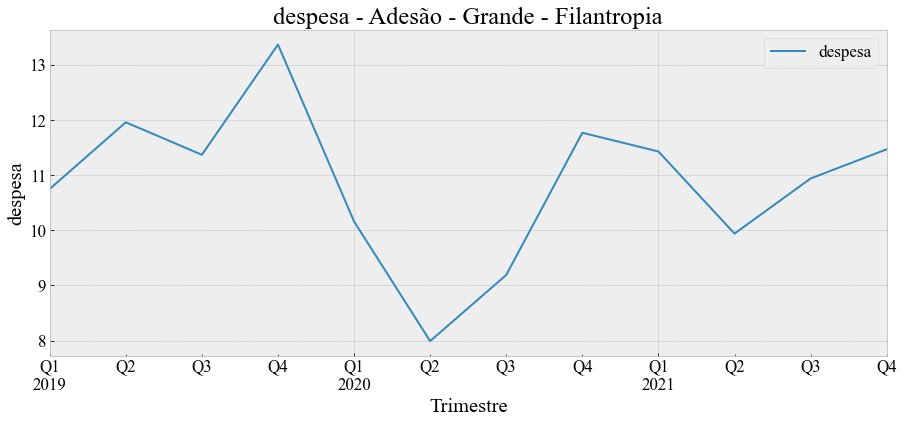

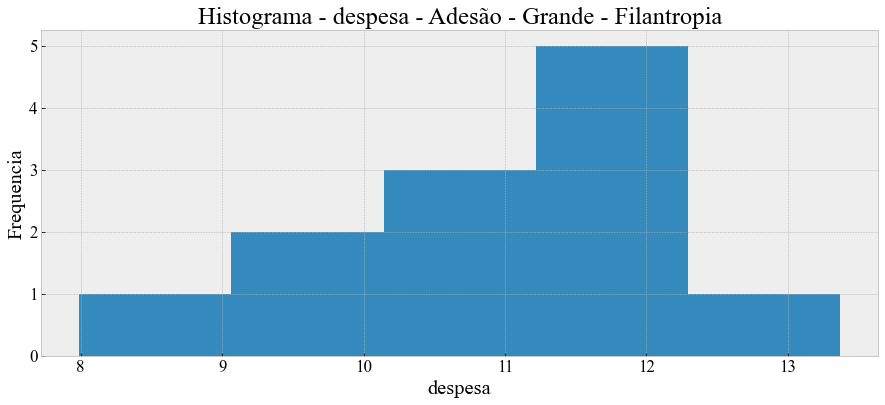

despesa_diff


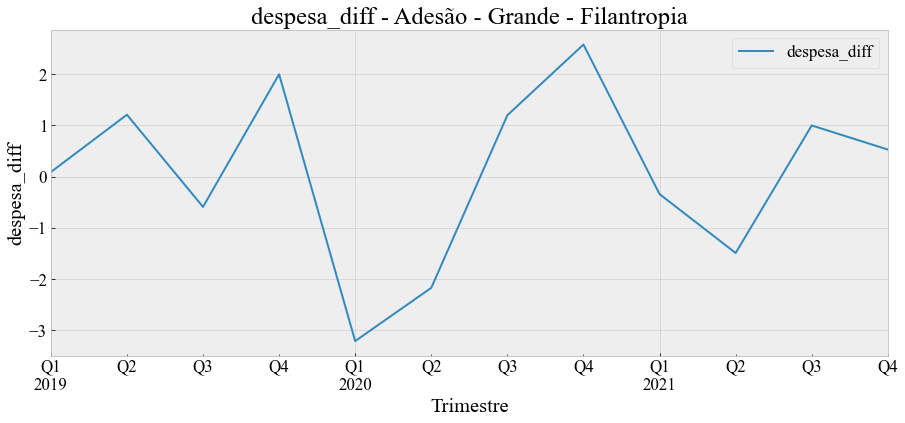

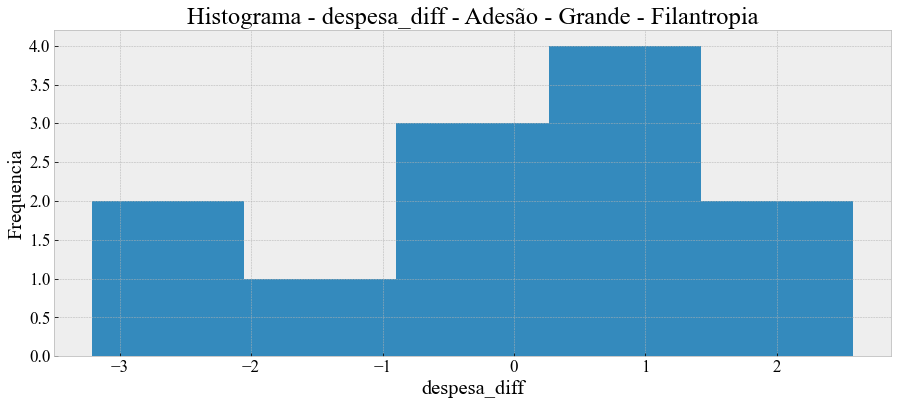

In [267]:
for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

## Forecast da Receita - Random Forest

In [268]:
ans_agrup_rec = ans_agrup_full[['n_tri','n_tri_l1','n_ops','receita','receita_diff','receita_diff_l1','receita_diff_l2','benefm','IPCA','Selic','Dolar','Dolar_diff','dmy_covid']]

ans_agrup_rec = ans_agrup_rec.dropna()

#Create X and y object
X = ans_agrup_rec[['n_tri','n_tri_l1','n_ops','receita_diff_l1','receita_diff_l2','benefm','IPCA','Selic','Dolar_diff','dmy_covid']]
y = ans_agrup_rec['receita_diff']

#Verificação da estacionariedade da receita
Augmented_Dickey_Fuller_Test_func(y, 'receita_diff')

Results of Dickey-Fuller Test for column receita_diff
Test Statistic                 -3.788422
p-value                         0.003028
No Lags Used                    0.000000
Number of Observartions Used   12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


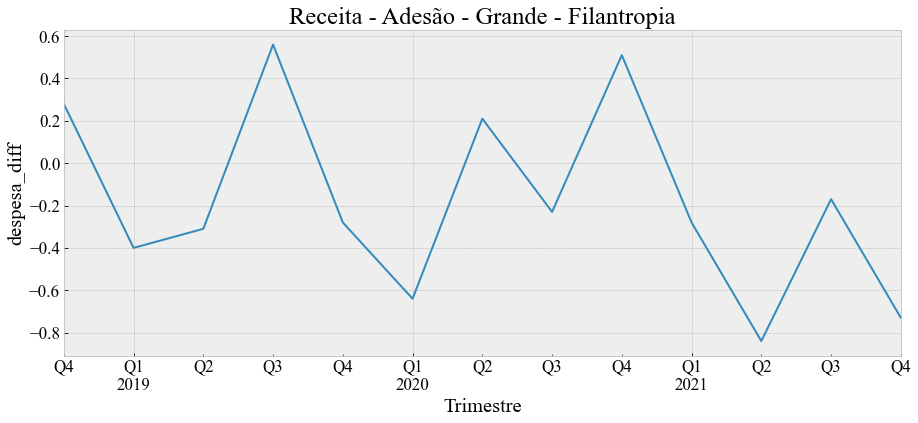

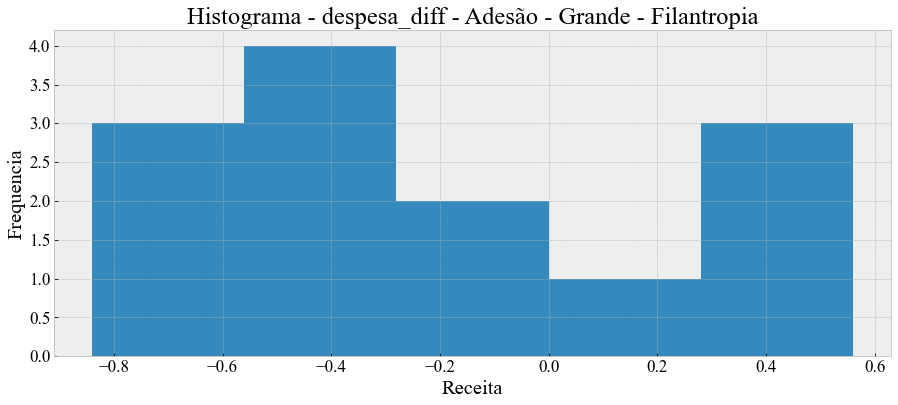

In [269]:
y.plot(y = 'Receita', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y.hist(bins='auto',figsize=(15,6))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [270]:
# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=3, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_train.fit(X_train)
X_train_scaled = scaler_X_train.transform(X_train)

y_train_reshaped = y_train.to_numpy().reshape(-1,1)

scaler_y_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_train.fit(y_train_reshaped)
y_train_scaled = scaler_y_train.transform(y_train_reshaped)

In [271]:
rf_regr = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100]},
                       scoring='r2', n_jobs=-1, verbose=True)

rf_regr.fit(X_train_scaled,y_train_scaled)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100]},
             scoring='r2', verbose=True)

In [272]:
X_test_scaled = scaler_X_train.transform(X_test)

y_pred = rf_regr.predict(X_test_scaled)
y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_test),list(y_pred))
print(rf_regr.best_params_)

Mean_Squared_Error_(MSE) is : 0.39463100000000023
Root_Mean_Squared_Error_(RMSE) is : 0.6281966252695093
Mean_Absolute_Error_(MAE) is : 0.5683333333333334
Mean_Absolute_Percentage_Error (MAPE) is : 1.0196027269355228
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 1.8683834048640915
Coefficient of determination R^2 is : -3.5851781564678555

{'max_features': 0.5, 'n_estimators': 10}


In [273]:
fi = pd.DataFrame( {'features': X_train.columns,
                    'importance': rf_regr.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
6,IPCA,0.254764
1,n_tri_l1,0.216980
7,Selic,0.182078
8,Dolar_diff,0.164921
4,receita_diff_l2,0.055848
0,n_tri,0.049604
5,benefm,0.042083
3,receita_diff_l1,0.033722
2,n_ops,0.000000
9,dmy_covid,0.000000


In [274]:
df_pred = pd.DataFrame(y_pred, columns=['receita'])
df_pred

,receita
0,-0.092000
1,0.020000
2,0.037000


In [275]:
actual_df = pd.DataFrame(ans_agrup['receita'].iloc[:-3])

display(actual_df)

res = inverse_diff(actual_df,df_pred)

res

,receita
trimestre,
2019Q1,15.560000
2019Q2,15.250000
2019Q3,15.810000
2019Q4,15.530000
2020Q1,14.890000
2020Q2,15.100000
2020Q3,14.870000
2020Q4,15.380000
2021Q1,15.100000


,receita,receita_1st_inv_diff
0,-0.092000,15.008000
1,0.020000,15.028000
2,0.037000,15.065000


In [276]:
timeseries_evaluation_metrics_func(list(ans_agrup['receita'].iloc[-3:]),list(res['receita_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 1.4487910000000002
Root_Mean_Squared_Error_(RMSE) is : 1.203657343266762
Mean_Absolute_Error_(MAE) is : 1.1303333333333334
Mean_Absolute_Percentage_Error (MAPE) is : 0.08221540511232096
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.0785020553538705
Coefficient of determination R^2 is : -8.505116635077993



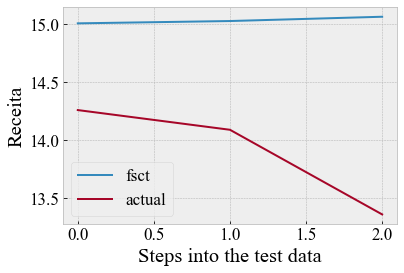

In [277]:
plt.plot(list(res['receita_1st_inv_diff']))
plt.plot(list(ans_agrup['receita'].iloc[-3:]))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [278]:
#dataframe teste para os 3 próximos anos

receita_l1_list = [y.iloc[-1]]
receita_l1_list_temp = [np.nan]*11
receita_l1_list.extend(receita_l1_list_temp)

receita_l2_list = [y.iloc[-2]]
receita_l2_list_temp = [np.nan]*11
receita_l2_list.extend(receita_l2_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_list = [ans_agrup_rec['benefm'].iloc[-1]]*12

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],
         'n_ops': [2.0]*12,
         'receita_diff_l1':  receita_l1_list,
         'receita_diff_l2': receita_l2_list,
         'benefm': benefm_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'dmy_covid':[1.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_pred_test

,n_tri,n_tri_l1,n_ops,receita_diff_l1,receita_diff_l2,benefm,IPCA,Selic,Dolar_diff,dmy_covid
2022Q1,1,4,2.000000,-0.730000,-0.170000,5279.000000,0.032007,0.000242,0.102400,1.000000
2022Q2,2,1,2.000000,NaN,NaN,5279.000000,0.022150,0.000288,-0.493667,1.000000
2022Q3,3,2,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.525100,1.000000
2022Q4,4,3,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.140000,1.000000
2023Q1,1,4,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,-0.105000,1.000000
2023Q2,2,1,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.305000,1.000000
2023Q3,3,2,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.050000,1.000000
2023Q4,4,3,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.150000,1.000000
2024Q1,1,4,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.050000,1.000000
2024Q2,2,1,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.050000,1.000000


In [279]:
y_pred_list = []

for i in range(len(df_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_test = df_pred_test.iloc[:i+1]
    X_test_scaled_test = scaler_X_train.transform(X_test)

    y_pred = rf_regr.predict(X_test_scaled_test)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_pred_test)-1:
        df_pred_test['receita_diff_l1'].iloc[i+1] = y_pred[-1]
        df_pred_test['receita_diff_l2'].iloc[i+1] = df_pred_test['receita_diff_l1'].iloc[i:i+1]

display(df_pred_test)

y_pred

,n_tri,n_tri_l1,n_ops,receita_diff_l1,receita_diff_l2,benefm,IPCA,Selic,Dolar_diff,dmy_covid
2022Q1,1,4,2.000000,-0.730000,-0.170000,5279.000000,0.032007,0.000242,0.102400,1.000000
2022Q2,2,1,2.000000,-0.351000,-0.730000,5279.000000,0.022150,0.000288,-0.493667,1.000000
2022Q3,3,2,2.000000,0.152000,-0.351000,5279.000000,0.030000,0.000200,0.525100,1.000000
2022Q4,4,3,2.000000,0.039000,0.152000,5279.000000,0.030000,0.000200,0.140000,1.000000
2023Q1,1,4,2.000000,0.002000,0.039000,5279.000000,0.030000,0.000200,-0.105000,1.000000
2023Q2,2,1,2.000000,-0.117000,0.002000,5279.000000,0.030000,0.000200,0.305000,1.000000
2023Q3,3,2,2.000000,0.004000,-0.117000,5279.000000,0.030000,0.000200,0.050000,1.000000
2023Q4,4,3,2.000000,0.096000,0.004000,5279.000000,0.030000,0.000200,0.150000,1.000000
2024Q1,1,4,2.000000,0.002000,0.096000,5279.000000,0.030000,0.000200,0.050000,1.000000
2024Q2,2,1,2.000000,-0.141000,0.002000,5279.000000,0.030000,0.000200,0.050000,1.000000


array([-0.351,  0.152,  0.039,  0.002, -0.117,  0.004,  0.096,  0.002,
       -0.141,  0.096,  0.004, -0.08 ])

In [280]:
df_pred = pd.DataFrame(y_pred, columns=['receita'], index = index_df_pred_test)
df_pred

,receita
2022Q1,-0.351000
2022Q2,0.152000
2022Q3,0.039000
2022Q4,0.002000
2023Q1,-0.117000
2023Q2,0.004000
2023Q3,0.096000
2023Q4,0.002000
2024Q1,-0.141000
2024Q2,0.096000


In [281]:
actual_df = pd.DataFrame(ans_agrup_rec['receita'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_pred)
pred_res.rename({'receita_1st_inv_diff': 'receita_pred'}, axis=1, inplace=True)
pred_res['receita_pred']

2022Q1   13.009000
2022Q2   13.161000
2022Q3   13.200000
2022Q4   13.202000
2023Q1   13.085000
2023Q2   13.089000
2023Q3   13.185000
2023Q4   13.187000
2024Q1   13.046000
2024Q2   13.142000
2024Q3   13.146000
2024Q4   13.066000
Name: receita_pred, dtype: float64

In [282]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['receita'])
ans_agrup_join = ans_agrup_temp.append(pd.DataFrame(pred_res['receita_pred']))
ans_agrup_join

,receita,receita_pred
2018Q1,14.280000,NaN
2018Q2,14.880000,NaN
2018Q3,15.680000,NaN
2018Q4,15.960000,NaN
2019Q1,15.560000,NaN
2019Q2,15.250000,NaN
2019Q3,15.810000,NaN
2019Q4,15.530000,NaN
2020Q1,14.890000,NaN
2020Q2,15.100000,NaN


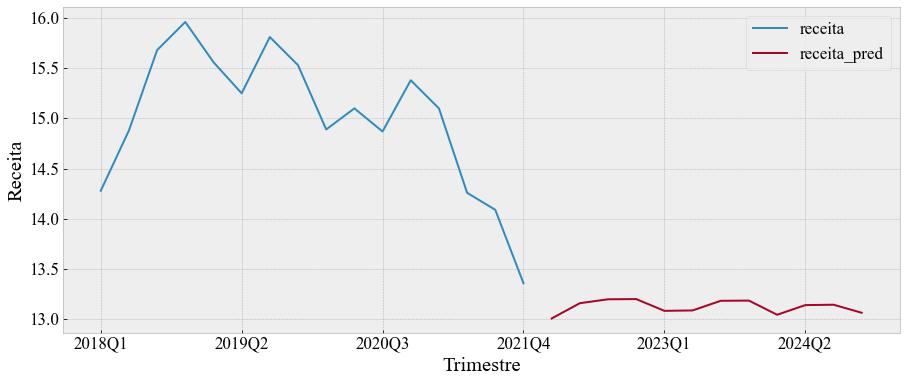

In [283]:
ans_agrup_join.plot(figsize=(15,6))
plt.legend(['receita','receita_pred'])
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()

## Forecast Despesa

In [284]:
ans_agrup_desp = ans_agrup_full[['n_tri','n_tri_l1','n_ops','despesa','despesa_diff','despesa_diff_l1','despesa_diff_l2','benefm','IPCA','Selic','Dolar','Dolar_diff','dmy_covid']]

ans_agrup_desp = ans_agrup_desp.dropna()

#Create X and y object
X = ans_agrup_desp[['n_tri','n_tri_l1','n_ops','despesa_diff_l1','despesa_diff_l2', 'IPCA','Selic','Dolar','dmy_covid']]
y = ans_agrup_desp['despesa_diff']

Augmented_Dickey_Fuller_Test_func(y, 'despesa')

Results of Dickey-Fuller Test for column despesa
Test Statistic                 -3.595196
p-value                         0.005854
No Lags Used                    1.000000
Number of Observartions Used   11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


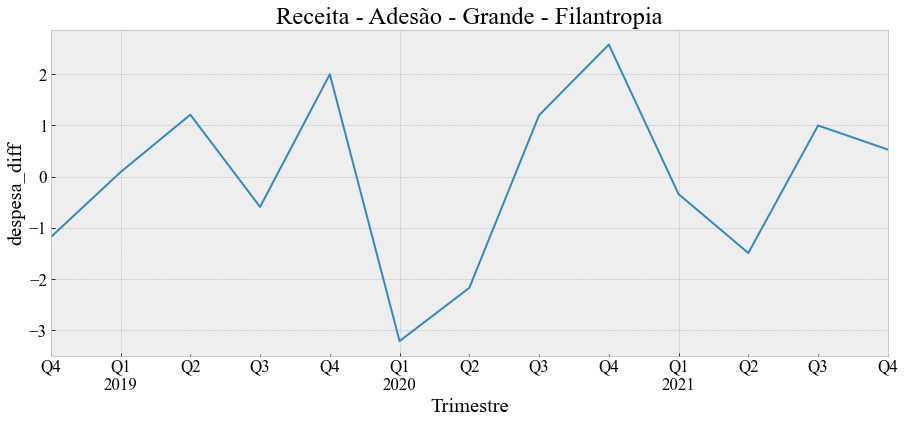

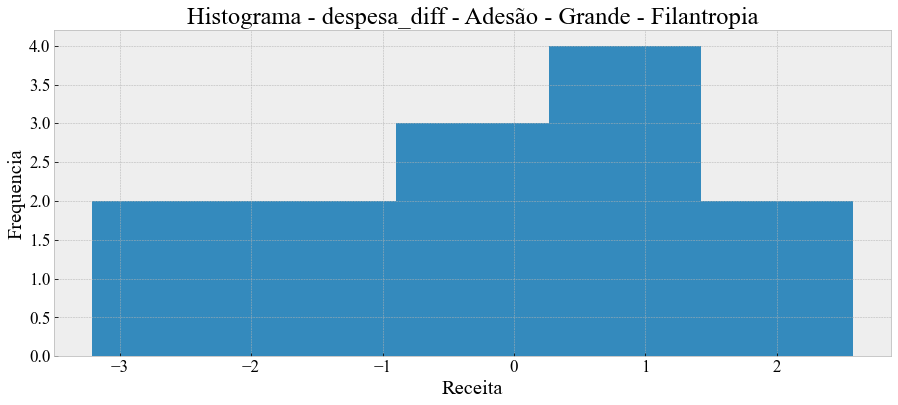

In [285]:
y.plot(y = 'Despesa', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y.hist(bins='auto',figsize=(15,6))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [286]:
# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=3, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_train.fit(X_train)
X_train_scaled = scaler_X_train.transform(X_train)

y_train_reshaped = y_train.to_numpy().reshape(-1,1)

scaler_y_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_train.fit(y_train_reshaped)
y_train_scaled = scaler_y_train.transform(y_train_reshaped)

In [287]:
rf_regr = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100]},
                       scoring='r2', n_jobs=-1, verbose=True)

rf_regr.fit(X_train_scaled,y_train_scaled)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100]},
             scoring='r2', verbose=True)

In [288]:
X_test_scaled = scaler_X_train.transform(X_test)

y_pred = rf_regr.predict(X_test_scaled)
y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_test),list(y_pred))
print(rf_regr.best_params_)

Mean_Squared_Error_(MSE) is : 1.634337629629629
Root_Mean_Squared_Error_(RMSE) is : 1.2784121517060252
Mean_Absolute_Error_(MAE) is : 1.0353333333333332
Mean_Absolute_Percentage_Error (MAPE) is : 1.1086361628185093
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 1.039249658242895
Coefficient of determination R^2 is : -0.40067406885431023

{'max_features': 0.8, 'n_estimators': 15}


In [289]:
fi = pd.DataFrame( {'features': X_train.columns,
                    'importance': rf_regr.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
5,IPCA,0.371800
4,despesa_diff_l2,0.213825
6,Selic,0.143337
7,Dolar,0.099409
8,dmy_covid,0.072255
1,n_tri_l1,0.071410
0,n_tri,0.016372
3,despesa_diff_l1,0.011591
2,n_ops,0.000000


In [290]:
df_pred = pd.DataFrame(y_pred, columns=['despesa'])
df_pred

,despesa
0,0.489333
1,0.855333
2,1.512000


In [291]:
actual_df = pd.DataFrame(ans_agrup_desp['despesa'].iloc[:-3])

display(actual_df)

res = inverse_diff(actual_df,df_pred)

res

,despesa
trimestre,
2018Q4,10.660000
2019Q1,10.750000
2019Q2,11.960000
2019Q3,11.370000
2019Q4,13.370000
2020Q1,10.160000
2020Q2,7.990000
2020Q3,9.190000
2020Q4,11.770000


,despesa,despesa_1st_inv_diff
0,0.489333,11.919333
1,0.855333,12.774667
2,1.512000,14.286667


In [292]:
timeseries_evaluation_metrics_func(list(ans_agrup['despesa'].iloc[-3:]),list(res['despesa_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 5.0724577777777755
Root_Mean_Squared_Error_(RMSE) is : 2.25221175242866
Mean_Absolute_Error_(MAE) is : 2.2102222222222214
Mean_Absolute_Percentage_Error (MAPE) is : 0.2041329570308005
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.184846452992273
Coefficient of determination R^2 is : -11.604815285217272



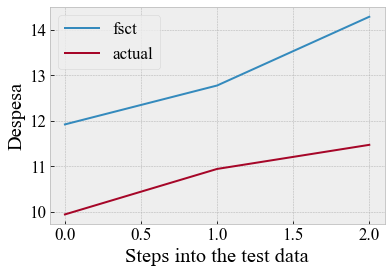

In [293]:
plt.plot(list(res['despesa_1st_inv_diff']))
plt.plot(list(ans_agrup['despesa'].iloc[-3:]))
plt.legend(['fsct','actual'])
plt.ylabel('Despesa')
plt.xlabel('Steps into the test data')
plt.show()

In [294]:
#dataframe teste para os 3 próximos anos

despesa_l1_list = [y.iloc[-1]]
despesa_l1_list_temp = [np.nan]*11
despesa_l1_list.extend(despesa_l1_list_temp)

despesa_l2_list = [y.iloc[-2]]
despesa_l2_list_temp = [np.nan]*11
despesa_l2_list.extend(despesa_l2_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_list = [ans_agrup_rec['benefm'].iloc[-1]]*12

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)


input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],
         'n_ops': [2.0]*12,
         'despesa_diff_l1':  despesa_l1_list,
         'despesa_diff_l2': despesa_l2_list,
         'benefm': benefm_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'dmy_covid':[1.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_pred_test

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm,IPCA,Selic,Dolar_diff,dmy_covid
2022Q1,1,4,2.000000,0.530000,1.000000,5279.000000,0.032007,0.000242,0.102400,1.000000
2022Q2,2,1,2.000000,NaN,NaN,5279.000000,0.022150,0.000288,-0.493667,1.000000
2022Q3,3,2,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.525100,1.000000
2022Q4,4,3,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.140000,1.000000
2023Q1,1,4,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,-0.105000,1.000000
2023Q2,2,1,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.305000,1.000000
2023Q3,3,2,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.050000,1.000000
2023Q4,4,3,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.150000,1.000000
2024Q1,1,4,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.050000,1.000000
2024Q2,2,1,2.000000,NaN,NaN,5279.000000,0.030000,0.000200,0.050000,1.000000


In [295]:
y_pred_list = []

for i in range(len(df_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_test = df_pred_test.iloc[:i+1]
    X_test_scaled_test = scaler_X_train.transform(X_test)

    y_pred = rf_regr.predict(X_test_scaled_test)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_pred_test)-1:
        df_pred_test['despesa_diff_l1'].iloc[i+1] = y_pred[-1]
        df_pred_test['despesa_diff_l2'].iloc[i+1] = df_pred_test['despesa_diff_l1'].iloc[i:i+1]

display(df_pred_test)

y_pred

ValueError: X has 10 features, but MinMaxScaler is expecting 9 features as input.

In [ ]:
df_pred = pd.DataFrame(y_pred, columns=['despesa'], index = index_df_pred_test)
df_pred

,despesa
2022Q1,0.478000
2022Q2,0.759333
2022Q3,0.997333
2022Q4,1.176667
2023Q1,0.420667
2023Q2,0.759333
2023Q3,0.997333
2023Q4,1.176667
2024Q1,0.420667
2024Q2,0.759333


In [ ]:
actual_df = pd.DataFrame(ans_agrup_desp['despesa'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_pred)
pred_res.rename({'despesa_1st_inv_diff': 'despesa_pred'}, axis=1, inplace=True)
pred_res['despesa_pred']

2022Q1   11.948000
2022Q2   12.707333
2022Q3   13.704667
2022Q4   14.881333
2023Q1   15.302000
2023Q2   16.061333
2023Q3   17.058667
2023Q4   18.235333
2024Q1   18.656000
2024Q2   19.415333
2024Q3   20.412667
2024Q4   21.589333
Name: despesa_pred, dtype: float64

In [ ]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['despesa'])
ans_agrup_join = ans_agrup_temp.append(pd.DataFrame(pred_res['despesa_pred']))
ans_agrup_join

,despesa,despesa_pred
2018Q1,10.230000,NaN
2018Q2,11.770000,NaN
2018Q3,11.840000,NaN
2018Q4,10.660000,NaN
2019Q1,10.750000,NaN
2019Q2,11.960000,NaN
2019Q3,11.370000,NaN
2019Q4,13.370000,NaN
2020Q1,10.160000,NaN
2020Q2,7.990000,NaN


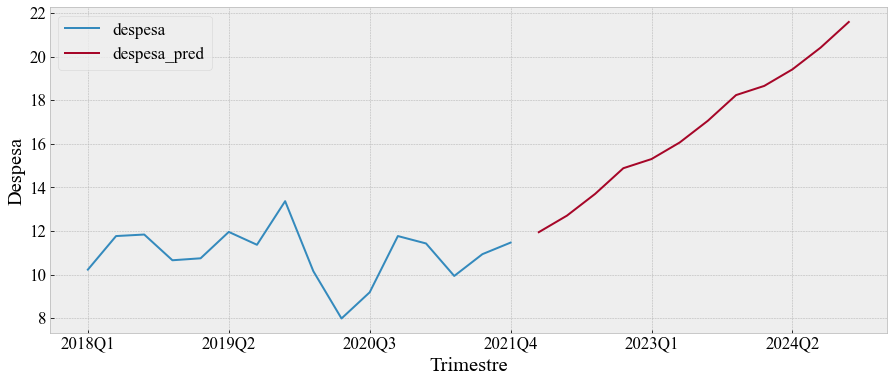

In [ ]:
ans_agrup_join.plot(figsize=(15,6))
plt.legend(['despesa','despesa_pred'])
plt.ylabel('Despesa')
plt.xlabel('Trimestre')
plt.show()